# GRID WORLD MultiAgent



# gym-gridMA

In [9]:
import gym
from gym import spaces
import pygame
import numpy as np
import matplotlib.pyplot as plt
import itertools

class MAGridWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, size=5, n_agents=1):
        self.size = size  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "target": spaces.Box(0, size - 1, shape=(2,), dtype=int),
            }
        )
        self.number_agents = n_agents
        # We have 4 actions, corresponding to "right", "up", "left", "down"
        if self.number_agents == 1:
            self.action_space = spaces.Discrete(5)
        else:
            self.action_space = [spaces.Discrete(5) for _ in range(self.number_agents)]
           
        self._target_location = [np.array([0,0]),np.array([size-1,size-1])]

        """
        The following dictionary maps abstract actions from `self.action_space` to 
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([0, 1]),
            2: np.array([-1, 0]),
            3: np.array([0, -1]),
            4: np.array([0, 0]),
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None
        
    def _get_obs(self):
        return self._agent_location

    def check(self, temp):
        for i in range(len(self._target_location)):
            if np.array_equal(temp, self._target_location[i]):
                return True
        for i in range(len(self._agent_location)):
            if np.array_equal(temp, self._agent_location[i]):
                return True
        return False
    
    def reset(self, seed=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)
        
        self.window = None
        self.clock = None
        
        # Choose the agent's location uniformly at random
        if self.number_agents==1:
            self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)
        else:
            self._agent_location = []
            for _ in range(self.number_agents):
                temp = self.np_random.integers(0, self.size, size=2, dtype=int)
                while self.check(temp):
                    temp = self.np_random.integers(0, self.size, size=2, dtype=int)
                self._agent_location.append(temp)
            
        observation = self._get_obs()

        if self.render_mode == "human":
            self._render_frame()

        return observation

    def step(self, action, state = None,flag=False):
        # Map the action (element of {0,1,2,3}) to the direction we walk in
        if self.number_agents == 1:
            direction = self._action_to_direction[action]
        else:
            direction = []
            for n in range(self.number_agents):
                direction.append(self._action_to_direction[action[n]])
                
        # We use `np.clip` to make sure we don't leave the grid
        if state is None:    
            if self.number_agents == 1:
                self._agent_location = np.clip(
                    self._agent_location + direction, 0, self.size - 1
                )
            else:
                self._agent_location = [l for l in np.clip(
                    np.array(self._agent_location) + np.array(direction), 0, self.size - 1
                )]
        else:
            if self.number_agents == 1:
                self._agent_location = np.clip(
                    state + direction, 0, self.size - 1
                )
            else:
                self._agent_location = [l for l in np.clip(
                    state.reshape(-1,2) + np.array(direction), 0, self.size - 1
                )]
                           
        # An episode is done iff the agent has reached the target
        if self.number_agents == 1:
            terminated = np.array_equal(self._agent_location, self._target_location[0]) \
                        or np.array_equal(self._agent_location, self._target_location[1]) 
            reward = 1 if terminated else 0  # Binary sparse rewards
            observation = self._get_obs()
        else:
            terminated = []
            for n in range(self.number_agents):
                t = np.array_equal(self._agent_location[n], self._target_location[0]) \
                    or np.array_equal(self._agent_location[n], self._target_location[1]) 
                terminated.append(t)
            observation = self._get_obs()
            
            # check for collisions which will produce bad reward
            reward = -1
            for c in itertools.combinations(range(self.number_agents),2):
                if np.array_equal(self._agent_location[c[0]],self._agent_location[c[1]]):
                    if np.any([np.array_equal(self._agent_location[c[0]],x) for x in self._target_location]):
                        continue 
                    reward += -3
                    
            reward = 0 if np.all(np.array(terminated)) else reward
            terminated = np.all(np.array(terminated))
        
        if self.render_mode == "human" and flag:
            self._render_frame()

        return observation, reward, terminated

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # First we draw the target
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location[0],
                (pix_square_size, pix_square_size),
            ),
        )
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location[1],
                (pix_square_size, pix_square_size),
            ),
        )
        # Now we draw the agent
        if self.number_agents == 1:
            pygame.draw.circle(
                canvas,
                (0, 0, 255),
                (self._agent_location + 0.5) * pix_square_size,
                pix_square_size / 3,
            )
        else:
            for n in range(self.number_agents):
                pygame.draw.circle(
                canvas,
                (0, 0, 255),
                (self._agent_location[n] + 0.5) * pix_square_size,
                pix_square_size / 3,
            )
            

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

In [10]:
n = 2 #robots
m = 5 # size of grid
grid = MAGridWorldEnv(size=m, n_agents=n,render_mode="rgb_array")

grid.reset(0)
#time.sleep(5)
#grid.close()

[array([4, 3]), array([2, 1])]

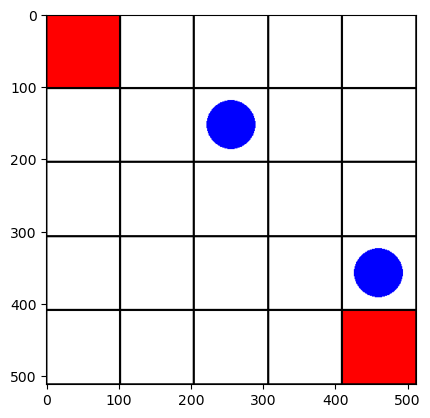

In [7]:
plt.imshow(grid.render())
plt.show()

In [11]:
grid.step(action=[2,0,1])

([array([3, 3]), array([3, 1])], -1, False)

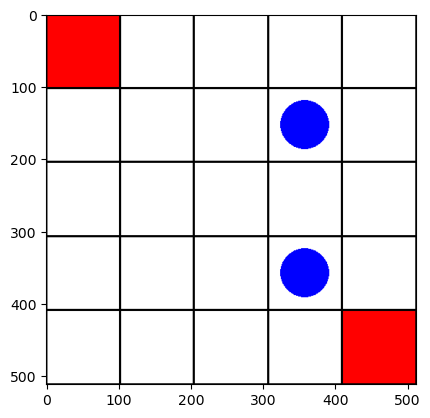

In [12]:
plt.imshow(grid.render())
plt.show()

In [13]:
np.vstack(grid._agent_location).flatten().tolist()

[3, 3, 3, 1]

In [30]:
len(grid._action_to_direction)

5

# Monte Carlo with Greedy policy 

In [14]:
### state space, is a permutation with replacement
### of m elements with 2*n dimention. "cartesian product"

z = np.array(list(itertools.product(np.arange(m), repeat=2*n)))
z.shape

(625, 4)

In [15]:
### another way to obtain the state space
x = [np.arange(m)]*(2*n)
y = np.array(np.meshgrid(*x)).T.reshape(-1,2*n)
y.shape

(625, 4)

In [16]:
### actions
a = np.array(list(itertools.product(np.arange(len(grid._action_to_direction)), repeat=n)))
a.shape

(25, 2)

In [32]:
np.ones((a.shape[0]))/a.shape[0]
np.random.choice(5, 2,p=np.ones((5))/5)

array([0, 3])

In [17]:
dimension = [m]*2*n
v = np.random.randn(*dimension)

y[34,:],v[tuple(np.vstack(y[34,:]).flatten())]

(array([1, 4, 1, 0]), 0.18079376068913106)

In [26]:
d = dict()
d.update({tuple(np.vstack(y[34,:]).flatten()):2.5})
print(d)

{(1, 4, 1, 0): 2.5}


In [54]:
from IPython.display import clear_output
from collections import defaultdict

def MC_gridMA(env, agents, num_episodes=10_000, disc=0.9):
    env.render_mode = None
    
    a = len(env._action_to_direction)
    
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    for i_episode in range(1, num_episodes + 1):
        if i_episode % 100 == 0:
            clear_output(wait=True)
            print("\rEpisode {} %.".format(i_episode/num_episodes * 100))
        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(30):
            action = np.random.choice(a, agents,p=np.ones((a))/a)
            next_state, reward, done = env.step(action)
            episode.append((tuple(np.vstack(state).flatten()), action, reward))
            if done:
                break
            state = next_state

        # Find all states the we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        states_in_episode = set([tuple(x[0]) for x in episode])
        for state in states_in_episode:
            # Find the first occurance of the state in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(disc**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]

    return V    

In [55]:
values = MC_gridMA(grid, n)

Episode 100.0 %.


In [58]:
def simulation(env, policy, actions):
    env.render_mode = "human"
    T = 30 ### number of steps in one episode
    state = env.reset()
    for t in range(T):
        best = np.zeros(actions.shape[0])
        for k,a in enumerate(actions):
            n_state, reward, _ = env.step(a,np.array(state))
            best[k] = policy[tuple(np.vstack(n_state).flatten())]
        act = np.argmax(best)
        state, _, ter = env.step(actions[act],np.array(state), True)
        if ter:
            print('goal reached')
            break
    env.close()

simulation(grid,values,a)

goal reached
